In [1]:
from pymavlink import mavutil
import math
import tkinter as tk
import socket
import time
import helper
import threading
import torch
import torch.nn as nn
import numpy as np
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [2]:
SIM_COMPUTER_IP = '192.168.1.110'  # IP address of the simulation computer
PORT = 15000  # The same port as used by the server

In [3]:
def send_command(command):
    with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
        s.connect((SIM_COMPUTER_IP, PORT))
        s.sendall(command.encode('utf-8'))

def start_instance(instance_id, out_port):
    send_command(f"start {instance_id} {out_port}")

def stop_instance(instance_id):
    send_command(f"stop {instance_id}")

def connect(port):
    connection = mavutil.mavlink_connection(f'udpin:0.0.0.0:{port}') 

    connection.wait_heartbeat() #wait until we hear a heartbeat from the copter

    return connection 

def get_current_position(connection):

    msg = connection.recv_match(type='LOCAL_POSITION_NED', blocking=True)

    north = msg.x
    east = msg.y
    down = -msg.z

    return(north, east, down)

def wait_for_gps_lock(connection, timeout=60):
    start_time = time.time()
    while True:
        # Check for timeout
        if time.time() - start_time > timeout:
            print("Timeout waiting for GPS lock.")
            return False
            
        # Fetch GPS_RAW_INT messages
        msg = connection.recv_match(type='GPS_RAW_INT', blocking=True, timeout=5)
        if not msg:
            print("No GPS data received.")
            continue
            
        # Check for 3D lock
        if msg.fix_type >= 3:
            print(f"GPS lock acquired with {msg.satellites_visible} satellites.")
            return True
        else:
            print(f"Current GPS fix type: {msg.fix_type}, waiting for 3D lock...")

        time.sleep(1)


def arm(mavlink_connection):
    """
    Arms vehicle and fly to a target altitude.
    :param mavlink_connection: The connection to the vehicle
    :param target_altitude: Target altitude in meters
    """

    print("Basic pre-arm checks")
    # Wait for vehicle to initialize and become ready
    while not mavlink_connection.wait_heartbeat(timeout=5):
        print("Waiting for vehicle heartbeat")

           
    print("Setting vehicle to GUIDED mode")
    mavlink_connection.mav.set_mode_send(mavlink_connection.target_system, mavutil.mavlink.MAV_MODE_FLAG_CUSTOM_MODE_ENABLED, 4) 

    # Wait a bit for the mode to change
    time.sleep(2)

    # Copter should arm in GUIDED mode
    mavlink_connection.mav.command_long_send(
        mavlink_connection.target_system, mavlink_connection.target_component,
        mavutil.mavlink.MAV_CMD_COMPONENT_ARM_DISARM,
        0,  # Confirmation
        1,  # 1 to arm
        0, 0, 0, 0, 0, 0  # Unused parameters for this command
    )
def waitForEKF2(connection):
    while True:
        msg = connection.recv_match(type='STATUSTEXT', blocking=True, timeout=5)
        if msg is None:
            continue
        text = msg.text.decode('utf-8')
        if "EKF2 IMU0 is using GPS" in text:
            print("Received EKF2 GPS lock message.")
            return True

def takeoff(mavlink_connection, alt):
    #Assumes you have already set to guided mode and armed.

    mavlink_connection.mav.command_long_send(mavlink_connection.target_system, mavlink_connection.target_component, 
                                 mavutil.mavlink.MAV_CMD_NAV_TAKEOFF, 0, 0, 0, 0, 0, 0, 0, alt)
    
    #See how the copter responded to the takeoff command
    msg = mavlink_connection.recv_match(type = 'COMMAND_ACK', blocking = True)
    #print(msg)

    while True:
        # Wait for the next LOCAL_POSITION_NED message
        msg = mavlink_connection.recv_match(type='LOCAL_POSITION_NED', blocking=True)
        
    
        # Check if altitude is within a threshold of the target altitude
        if abs(msg.z * -1 - alt) < 1.0:
            print("Reached target altitude")
            break

#send local frame coordinates and have copter fly over that spot.
def send_waypoint_local(connection, x, y, alt):
    connection.mav.send(mavutil.mavlink.MAVLink_set_position_target_local_ned_message
                    (10, connection.target_system, connection.target_component, mavutil.mavlink.MAV_FRAME_LOCAL_NED, 
                     int(0b010111111000), x, y, alt,
                      0, 0, 0, 0, 0, 0, 0, 0))

    time.sleep(1)


In [4]:
def plot_3d_paths(results):
    # Create a new figure for plotting
    fig = plt.figure(figsize=(10, 8))
    
    # Determine the number of subplots based on the number of paths
    num_paths = len(results)
    cols = 2  # You can adjust the number of columns based on your preference
    rows = (num_paths + cols - 1) // cols  # Calculate rows needed
    
    x_limits = (-10, 10)
    y_limits = (-10, 10)
    z_limits = (-10, 10)
    
    # Plot each path in a subplot
    for index, (pid, path) in enumerate(results.items(), start=1):
        ax = fig.add_subplot(rows, cols, index, projection='3d')
        # Assuming path is a list of [north, east, down] coordinates
        path = np.array(path)  # Convert path to a NumPy array for easier slicing
        
        # Create a color map
        points = np.arange(len(path))
        colors = cm.plasma(points / max(points))  # Normalize points for color mapping
        
        # Plot the 3D path with a color gradient
        ax.scatter(path[:, 0], path[:, 1], path[:, 2], c=colors, cmap='plasma', marker='o')
        
        # Plot the target point in red
        ax.plot([5], [5], [9], marker='o', color='red', markersize=10)
        
        ax.set_xlim(x_limits)
        ax.set_ylim(y_limits)
        ax.set_zlim(z_limits)
        
        ax.set_xlabel('North')
        ax.set_ylabel('East')
        ax.set_zlabel('Down')
        ax.set_title(f'PID {pid} Flight Path')

    plt.tight_layout()
    plt.show()


In [5]:
# GANN definitions #

class DroneNet(nn.Module):
    def __init__(self):
        super(DroneNet, self).__init__()
        self.fc1 = nn.Linear(3, 10)  # First hidden layer from 3 inputs to 10 nodes
        self.fc2 = nn.Linear(10, 5)  # Second hidden layer from 10 nodes to 5 nodes
        self.output = nn.Linear(5, 3)  # Output layer from 5 nodes to 3 outputs (NED coordinates)

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # Activation function for first hidden layer
        x = torch.relu(self.fc2(x))  # Activation function for second hidden layer
        x = self.output(x)  # Output layer, no activation (linear output)
        return x
    
def get_fitness(path, target):
    # calculate how close final position was to target and the total distance.
    # return a fitness that rewards closeness to target and minumum distance flown.
    final_position = path[-1]
    fp_north, fp_east, fp_down = final_position
    t_north, t_east, t_down = target

    distance_from_target = np.sqrt((fp_north-t_north)**2 + (fp_east-t_east)**2 + (fp_down-t_down)**2)

    total_distance = 0
    for i in range(1, len(path)):
        n, e, d = path[i]
        old_n, old_e, old_d = path[i-1]

        total_distance += np.sqrt((old_n-n)**2 + (old_e-e)**2 + (old_d-d)**2)
        
    distance_target_score = 1 / (distance_from_target + 1)
    distance_total_score = 1 / (total_distance + 1) 
    
    if distance_from_target > 20:
        distance_target_score = distance_target_score - 0.75
        
    distance_target_score = 1 / (distance_from_target + 1)
    
    fitness = distance_target_score + distance_total_score
    
    print(f"Fitness: {fitness} dist_from_target = {distance_from_target} and total_distace = {total_distance}")
    
    return fitness

def mutate(network, mutation_rate, mutation_strength):
    with torch.no_grad():
        for param in network.parameters():
            if random.random() < mutation_rate:
                mutation = torch.randn_like(param) * mutation_strength
                param.add_(mutation)

def crossover(parent1, parent2):
    child = DroneNet() 
    with torch.no_grad():
        for child_param, param1, param2 in zip(child.parameters(), parent1.parameters(), parent2.parameters()):
            mask = torch.bernoulli(torch.full_like(param1, 0.5))  # Randomly take weights from either parent
            child_param.data.copy_(param1.data * mask + param2.data * (1 - mask))
    return child

def initialize_population(size):
    return [DroneNet() for _ in range(size)]

def generate_new_population(population, fitness_scores, mutation_rate, mutation_strength):
    new_population = []
    population_size = len(population)
    
    # Select the best 2 dudes
    sorted_indices = sorted(range(len(fitness_scores)), key=lambda k: fitness_scores[k], reverse=True)
    for i in sorted_indices:
        print(f"indice: {i}")
        
    elite = [population[i] for i in sorted_indices[:2]]
    print(f"Parents: {sorted_indices[0]} and {sorted_indices[1]}")


    # Crossover and mutation to fill the new population
    while len(new_population) < population_size - len(elite):
        parent1, parent2 = random.sample(elite, 2)
        child = crossover(parent1, parent2)
        mutate(child, mutation_rate, mutation_strength)
        new_population.append(child)

    # Ensure that the total new population size does not exceed the original population size
    new_population.extend(elite[:population_size - len(new_population)])

    return new_population

def adjust_output(output):
    # Scale from [0, 1] to [1, 50]
    return 1 + 49 * output


Testing selection top 2 guys to crossover instead of top half of population
Mutation rate is 0.1 and mutation strength is 0.1
<----------------------- EPOCH 0 ------------------------->
starting instance 0 on port 14560
starting instance 1 on port 14561
starting instance 2 on port 14562
starting instance 3 on port 14563
starting instance 4 on port 14564
starting instance 5 on port 14565
instance 2 - Heartbeat Recieved!
instance 3 - Heartbeat Recieved!
instance 5 - Heartbeat Recieved!
instance 4 - Heartbeat Recieved!
instance 0 - Heartbeat Recieved!
instance 1 - Heartbeat Recieved!
instance 2 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 3 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 5 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 4 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 0 - arming thro

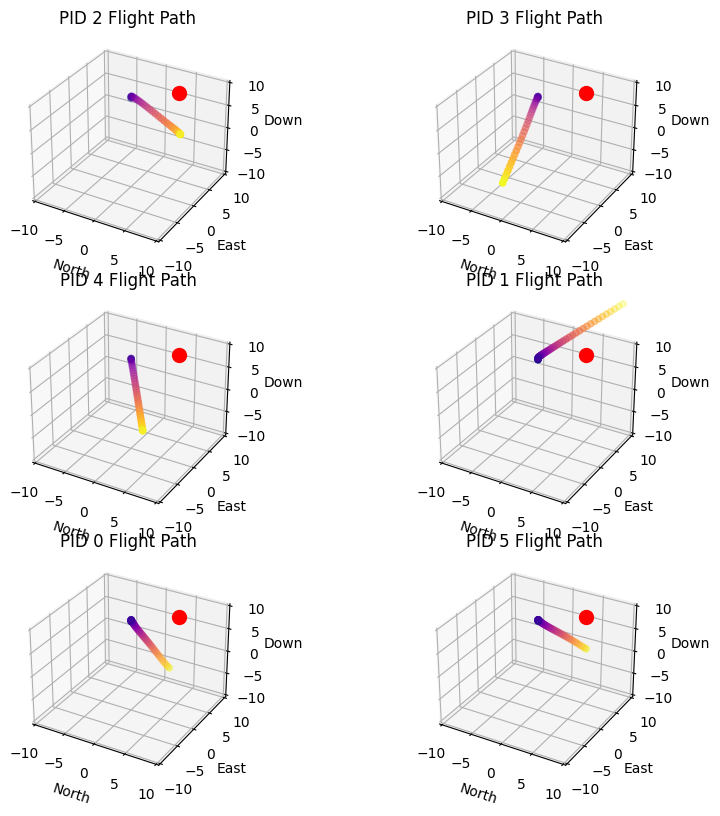

indice: 4
indice: 5
indice: 0
indice: 2
indice: 3
indice: 1
Parents: 4 and 5
<----------------------- EPOCH 1 ------------------------->
starting instance 6 on port 14566
starting instance 7 on port 14567
starting instance 8 on port 14568
starting instance 9 on port 14569
starting instance 10 on port 14570
starting instance 11 on port 14571
instance 6 - Heartbeat Recieved!
instance 8 - Heartbeat Recieved!
instance 9 - Heartbeat Recieved!
instance 11 - Heartbeat Recieved!
instance 10 - Heartbeat Recieved!
instance 7 - Heartbeat Recieved!
instance 6 - arming throttle in GUIDED mode.instance 8 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode

Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 9 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 11 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 10 - arming throttle in GUIDED mode.
Basic pre-arm checks
S

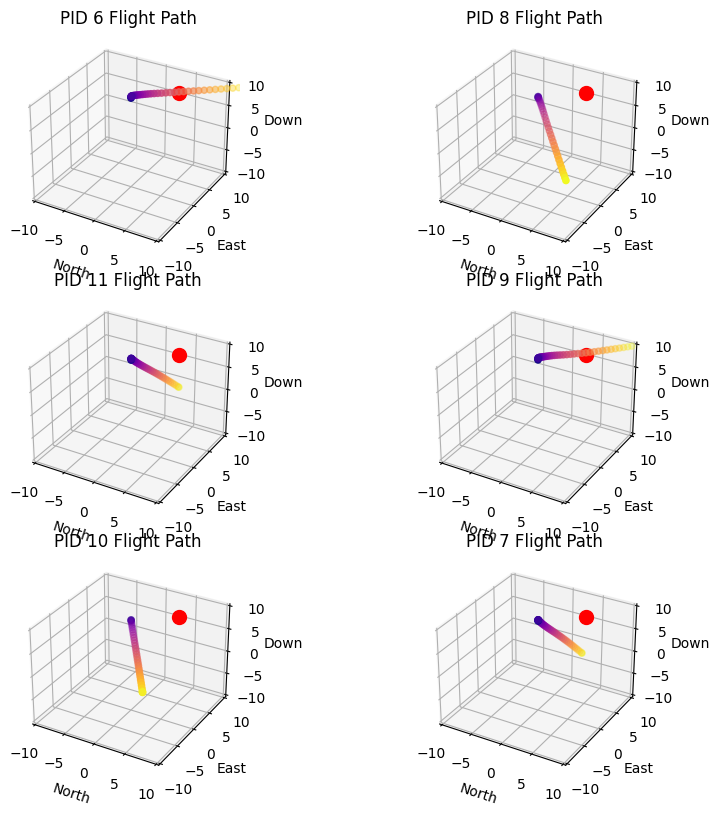

indice: 5
indice: 2
indice: 4
indice: 3
indice: 0
indice: 1
Parents: 5 and 2
<----------------------- EPOCH 2 ------------------------->
starting instance 12 on port 14572
starting instance 13 on port 14573
starting instance 14 on port 14574
starting instance 15 on port 14575
starting instance 16 on port 14576
starting instance 17 on port 14577
instance 17 - Heartbeat Recieved!
instance 12 - Heartbeat Recieved!
instance 13 - Heartbeat Recieved!
instance 16 - Heartbeat Recieved!
instance 14 - Heartbeat Recieved!
instance 15 - Heartbeat Recieved!
instance 17 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 12 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 13 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 16 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 14 - arming throttle in GUIDED mode.
Basic pre-a

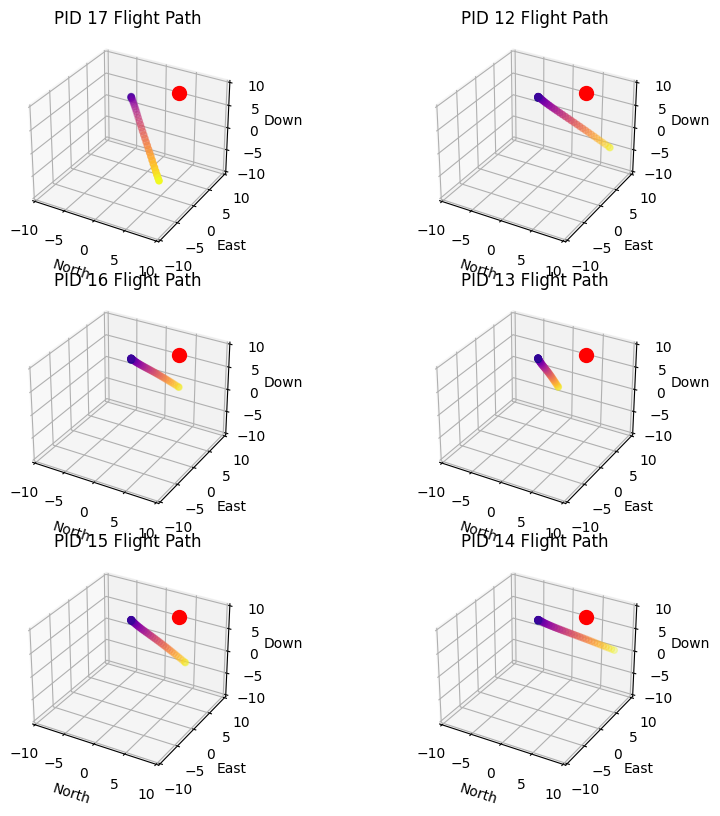

indice: 4
indice: 3
indice: 2
indice: 1
indice: 5
indice: 0
Parents: 4 and 3
<----------------------- EPOCH 3 ------------------------->
starting instance 18 on port 14578
starting instance 19 on port 14579
starting instance 20 on port 14580
starting instance 21 on port 14581
starting instance 22 on port 14582
starting instance 23 on port 14583
instance 22 - Heartbeat Recieved!
instance 20 - Heartbeat Recieved!
instance 23 - Heartbeat Recieved!
instance 21 - Heartbeat Recieved!
instance 18 - Heartbeat Recieved!
instance 19 - Heartbeat Recieved!
instance 22 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 20 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 23 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 21 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 18 - arming throttle in GUIDED mode.
Basic pre-a

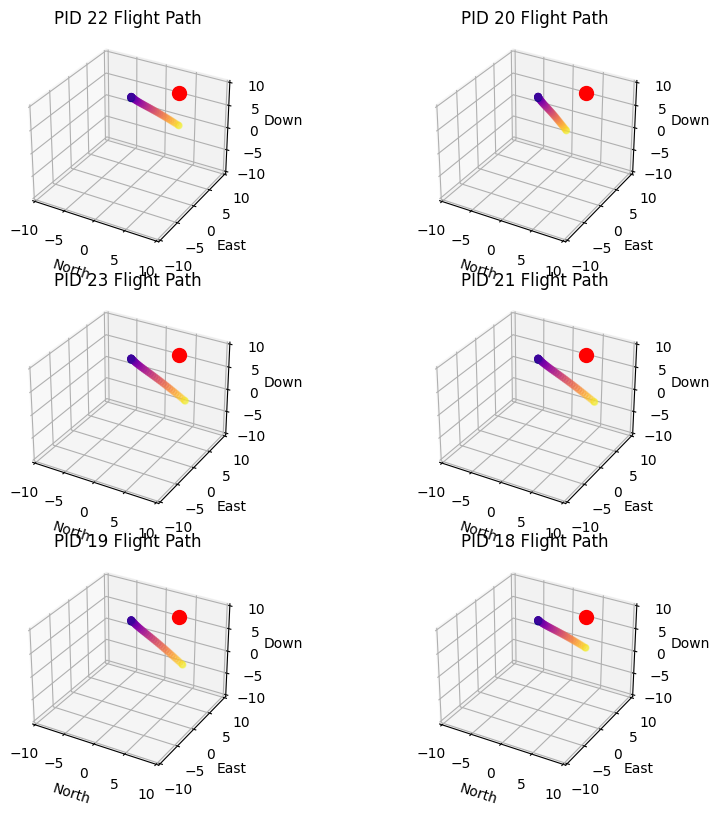

indice: 1
indice: 4
indice: 2
indice: 3
indice: 0
indice: 5
Parents: 1 and 4
<----------------------- EPOCH 4 ------------------------->
starting instance 24 on port 14584
starting instance 25 on port 14585
starting instance 26 on port 14586
starting instance 27 on port 14587
starting instance 28 on port 14588
starting instance 29 on port 14589
instance 29 - Heartbeat Recieved!
instance 26 - Heartbeat Recieved!
instance 27 - Heartbeat Recieved!
instance 28 - Heartbeat Recieved!
instance 24 - Heartbeat Recieved!
instance 25 - Heartbeat Recieved!
instance 29 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 26 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 27 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 28 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 24 - arming throttle in GUIDED mode.
Basic pre-a

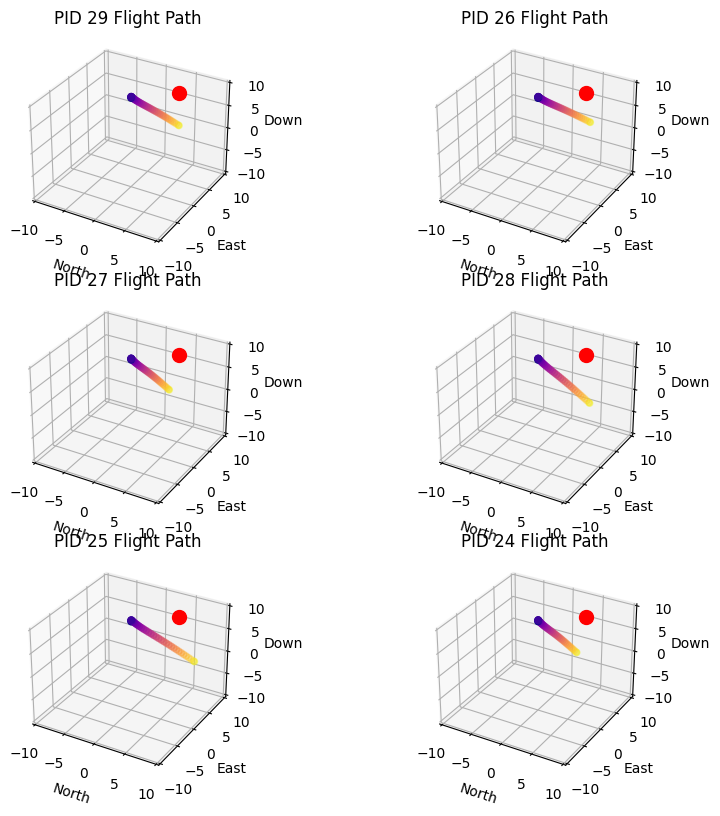

indice: 5
indice: 2
indice: 3
indice: 0
indice: 4
indice: 1
Parents: 5 and 2
<----------------------- EPOCH 5 ------------------------->
starting instance 30 on port 14590
starting instance 31 on port 14591
starting instance 32 on port 14592
starting instance 33 on port 14593
starting instance 34 on port 14594
starting instance 35 on port 14595
instance 32 - Heartbeat Recieved!
instance 35 - Heartbeat Recieved!
instance 30 - Heartbeat Recieved!
instance 33 - Heartbeat Recieved!
instance 31 - Heartbeat Recieved!
instance 34 - Heartbeat Recieved!
instance 32 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 35 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 30 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 33 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 31 - arming throttle in GUIDED mode.
Basic pre-a

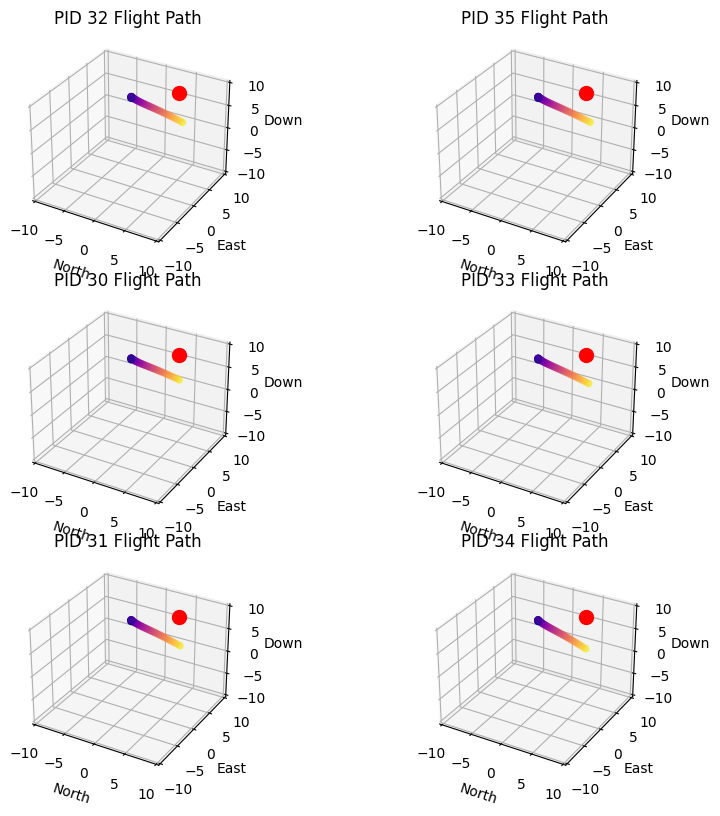

indice: 5
indice: 4
indice: 0
indice: 3
indice: 1
indice: 2
Parents: 5 and 4
<----------------------- EPOCH 6 ------------------------->
starting instance 36 on port 14596
starting instance 37 on port 14597
starting instance 38 on port 14598
starting instance 39 on port 14599
starting instance 40 on port 14600
starting instance 41 on port 14601
instance 36 - Heartbeat Recieved!
instance 38 - Heartbeat Recieved!
instance 37 - Heartbeat Recieved!
instance 40 - Heartbeat Recieved!
instance 41 - Heartbeat Recieved!
instance 39 - Heartbeat Recieved!
instance 36 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 38 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 37 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 40 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 41 - arming throttle in GUIDED mode.
Basic pre-a

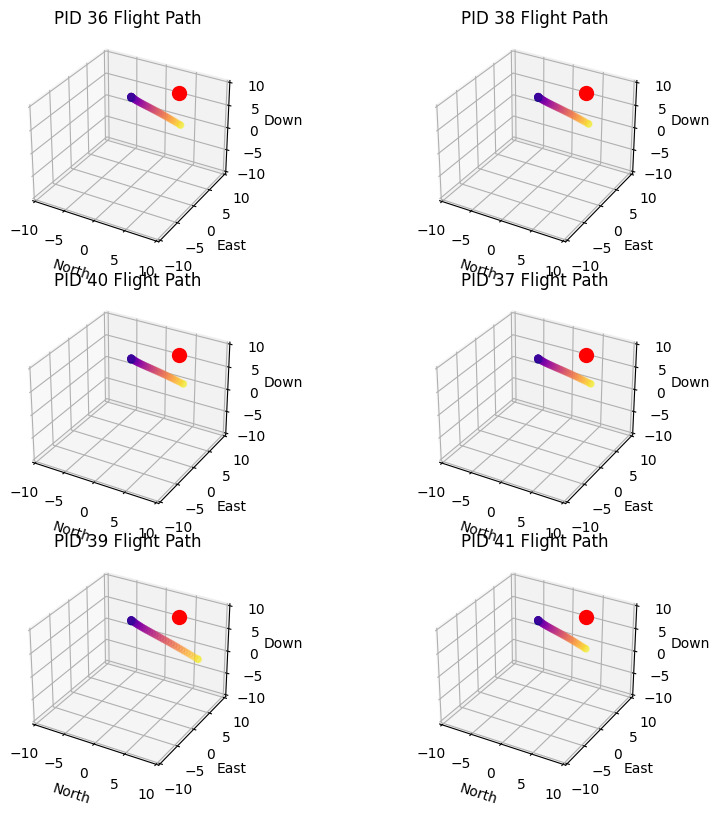

indice: 5
indice: 0
indice: 1
indice: 4
indice: 2
indice: 3
Parents: 5 and 0
<----------------------- EPOCH 7 ------------------------->
starting instance 42 on port 14602
starting instance 43 on port 14603
starting instance 44 on port 14604
starting instance 45 on port 14605
starting instance 46 on port 14606
starting instance 47 on port 14607
instance 43 - Heartbeat Recieved!
instance 45 - Heartbeat Recieved!
instance 46 - Heartbeat Recieved!
instance 44 - Heartbeat Recieved!
instance 47 - Heartbeat Recieved!
instance 42 - Heartbeat Recieved!


KeyboardInterrupt: 

In [6]:
def simulate_drone(pid, out_port, network, result_dict, results_lock):
    try:
        print(f"starting instance {pid} on port {out_port}")
        start_instance(pid, out_port)
        drone_connection = connect(out_port)

        # Print heartbeat information
        while True:
            msg = drone_connection.recv_match(type='HEARTBEAT', blocking=True)
            if not msg:
                print(f"instance {pid} - No heartbeat")
            else:
                print(f"instance {pid} - Heartbeat Recieved!")
                break

        time.sleep(40)

        print(f"instance {pid} - arming throttle in GUIDED mode.")
        arm(drone_connection)

        print(f"instance {pid} - sending takeoff command")
        takeoff(drone_connection, 10)
        
        #time.sleep(8)

        path = []

        for i in range(35):
            north, east, down = get_current_position(drone_connection)

            #print(f'Instance {pid} - North: {north}, East: {east}, Down: {down}')
            
            current_pos = [north, east, down]
            path.append(current_pos)

            with torch.no_grad():
                input_tensor = torch.tensor(current_pos, dtype=torch.float32).unsqueeze(0)
                next_position = network(input_tensor).numpy()[0]  # Remove batch dimension and convert to numpy
                next_position = adjust_output(next_position)

            new_north, new_east, new_down = next_position

            print(f"Instance {pid} sending neurotic waypoint: {new_north}, {new_east}, {new_down}")

            send_waypoint_local(drone_connection, new_north, new_east, new_down)
            time.sleep(1)
        

        print(f"stopping instance {pid}")
        stop_instance(pid)

        result_dict[pid] = path
    
    except Exception as e:
        print(f"Exception in thread {pid}: {e}")
        

def main():
    out_port_base = 14560
    pid_base = 0
    instance_count = 6  # Number of individuals (simulation instances) per epoch
    epochs = 50
    target = [5, 5, 9]
    population_size = instance_count
    mutation_rate = 0.1
    mutation_strength = 0.1
       
    print("Testing selection top 2 guys to crossover instead of top half of population")
    print(f"Mutation rate is {mutation_rate} and mutation strength is {mutation_strength}")

    # Initialize the population
    population = initialize_population(population_size)
    
    for j in range(epochs):
        threads = []
        results = {}
        results_lock = threading.Lock()

        print(f"<----------------------- EPOCH {j} ------------------------->")

        for i, network in enumerate(population):
            pid = pid_base + i
            out_port = out_port_base + i
            # Passing results_lock to ensure it is used in simulate_drone
            t = threading.Thread(target=simulate_drone, args=(pid, out_port, network, results, results_lock))
            t.start()
            threads.append(t)

        for t in threads:
            t.join(timeout=200)
            if t.is_alive():
                print("Warning: Thread timed out and may still be running.")
            else:
                print("Thread has completed execution.")

        fitness_scores = []
        with results_lock:
            for pid, path in results.items():
                fitness = get_fitness(path, target)
                fitness_scores.append(fitness)
                print(f"Instance: {pid} fitness: {fitness}")

            plot_3d_paths(results)

        population = generate_new_population(population, fitness_scores, mutation_rate, mutation_strength)

        pid_base += instance_count
        out_port_base += instance_count        

if __name__ == "__main__":
    main() 